   [Fri Jul 10 17:24:11 2020] Plotting the sample: AL1-Mitotic []
/software/system/jupyter/vbc_conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/system/jupyter/vbc_conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
   [Fri Jul 10 17:24:12 2020] Plotting the sample: Chicken []
/software/system/jupyter/vbc_conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/software/system/jupyter/vbc_conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10


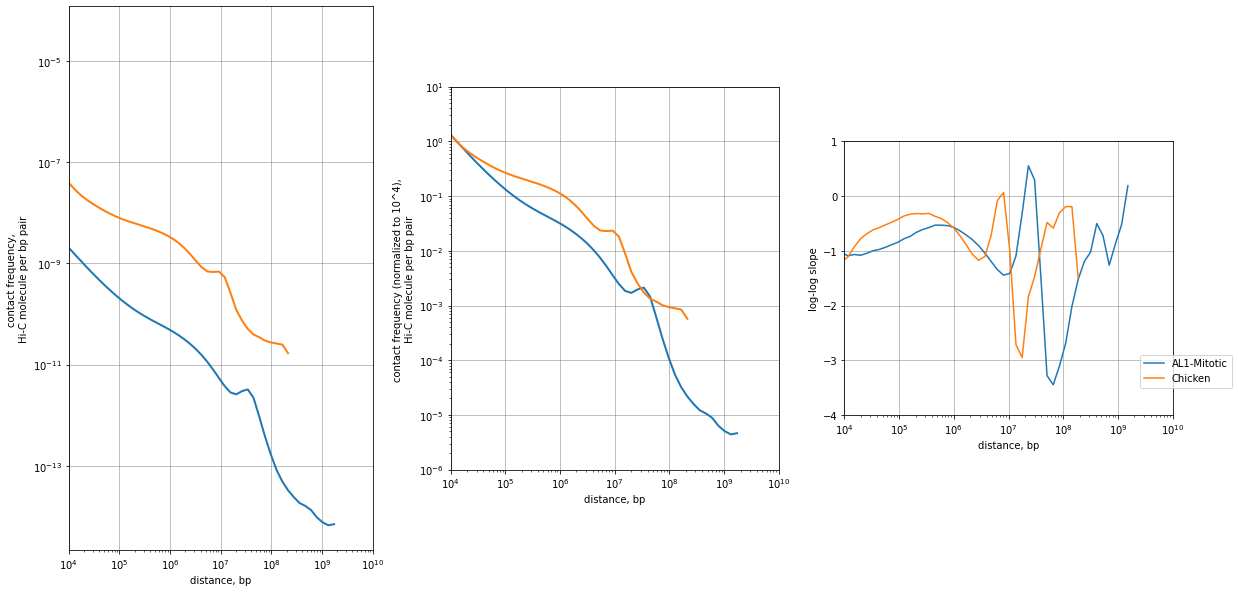

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import pairlib
import pairlib.scalings
import pairtools
import bioframe
import matplotlib.pyplot as plt
import matplotlib.gridspec
import sys
import time
import argparse
import pickle
import os
import os.path


def plotData(p_curves, p_curves_norm, p_derivatives, strSample, sc, chromosomes):
    filtered = sc.replace(-1, np.nan).dropna()
    strand_gb = filtered.query('(chrom1 == chrom2)')
    if len(chromosomes) != 0:
        arrChr = []
        for strChr in chromosomes:
            arrChr.append(f'(chrom1 == "{strChr}")')
        strQuery = " | ".join(arrChr)
        filtered = filtered.query(strQuery)
        strSample = strSample + f' ({",".join(chromosomes)})'
        print(strQuery)
    strand_gb = (filtered.query('(chrom1 != "!") & (chrom2 != "!") ').groupby(['strand1', 'strand2']))
    strand_gb = pd.concat( [ strand_gb.get_group(group) for i,group in enumerate( strand_gb.groups)] )    
    sc_agg = (strand_gb.groupby(['min_dist','max_dist']).agg({'n_pairs':'sum', 'n_bp2':'sum'}).reset_index())
    dist_bin_mids = np.sqrt(sc_agg.min_dist * sc_agg.max_dist)
    pair_frequencies = sc_agg.n_pairs / sc_agg.n_bp2
    mask = pair_frequencies > 0
    
    norm_freqs = pairlib.scalings.norm_scaling(dist_bin_mids, pair_frequencies, anchor=1e4)
    
    p_curves.loglog(dist_bin_mids[mask], 
                    pair_frequencies[mask], 
                    label=strSample, 
                    lw=2)
    p_curves_norm.loglog(dist_bin_mids[mask], 
                         norm_freqs[mask], 
                         label=strSample, 
                         lw=2)
    p_derivatives.semilogx(np.sqrt(dist_bin_mids.values[1:]*dist_bin_mids.values[:-1]), 
                           np.diff(np.log10(pair_frequencies.values)) / np.diff(np.log10(dist_bin_mids.values)),
                           label=strSample)



samples = [#['AL1-DpnII', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.DpnII.1e1-1e11.dat'],
           #['AL1-HindIII', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.HindIII.1e1-1e11.dat'],
           ['AL1-Mitotic', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/HiCUP/_amex_/AL1.Mitotic.1e1-1e11.dat'],
           #['Human', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/TADs/Wutz_et_al/ctrl.1e1-1e11.da'],
           #['Chicken', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/contact_probabilities/Chicken_30min.1e1-1e11.dat'],
           ['Chicken', '/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/contact_probabilities/4DNFI1TM5GVZ.1e1-1e11.dat']
           ]

xmin = 1e4
xmax = 1e10

fig = plt.figure(figsize=(20,10))
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=3)
p_curves = fig.add_subplot(gs[0, 0])
p_curves_norm = fig.add_subplot(gs[0, 1])
p_derivatives = fig.add_subplot(gs[0, 2])

for i, sample in enumerate(samples):
    sc = None
    chromosomes = []
    
    strSample = sample[0]
    with open(sample[1], 'rb') as data:
        record = pickle.load(data)
        if isinstance(record, dict):
            sc = record['data']
        else:
            sc = record
        if len(sample) > 2:
            chromosomes = sample[2:]
    ts = time.asctime(time.localtime())
    print(f"   [{ts}] Plotting the sample: {strSample} {chromosomes}", file=sys.stderr)
    plotData(p_curves, p_curves_norm, p_derivatives, strSample, sc, chromosomes)

    if i == 0:
        plt.sca(p_curves)
        plt.gca().set_aspect(1.0)
        plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.xlim([xmin, xmax])
        plt.grid(lw=0.5, color='gray')
        plt.ylabel('contact frequency, \nHi-C molecule per bp pair')
        plt.xlabel('distance, bp')
        
        plt.sca(p_curves_norm)
        plt.gca().set_aspect(1.0)
        plt.gca().xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.gca().yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=20))
        plt.xlim([xmin, xmax])
        plt.ylim([1e-6, 1e1])
        plt.grid(lw=0.5, color='gray')
        plt.ylabel('contact frequency (normalized to 10^4), \nHi-C molecule per bp pair')
        plt.xlabel('distance, bp')

        plt.sca(p_derivatives)
        plt.gca().set_aspect(1.0)
        plt.xlim([xmin, xmax])
        plt.ylim(-4, 1)
        plt.grid(lw=0.5, color='gray')
        plt.ylabel('log-log slope')    
        plt.xlabel('distance, bp')
        
        xpos = plt.gca().get_xticks()
        #xlabs = list(map(lambda x: f'{x/1000}K', xpos))
        #plt.xticks(xpos, xlabs)

plt.legend(loc=(0.9,0.1))

plt.savefig('/groups/tanaka/Projects/axolotl-genome/AmexG_v6.0/AmexG_v6.0_DD/work/manuscript/figures/fig3/3c2.pdf', dpi=300)

In [6]:
print(10^4)

14


In [7]:
print(1e4)

10000.0
